## 1. Introduction

On this blogpost we will try to predcit the fate of Game Of Thrones characters using Machine Learning. We will learn how to analyze data and how to find the best model for a classification task.

## 2. Dependencies

For this task we will use the following libraries: 
   
   * Numpy: For matrix and vector operations
   * Pandas: To load our data
   * Seaborn and Matplotlib: To visualize data
   * Sklearn: To train, create and validate our models with different hyper-parameters

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split 
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve 
from sklearn.metrics import confusion_matrix, classification_report


In [2]:
# plots' parameters with seaborn
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale = 1, rc = {"lines.linewidth": 2, 'font_family': [u'times']})

In [3]:
# Load our dataset
df = pd.read_csv("data/character-predictions.csv")

In [4]:
# Set seed for result reproductibility
seed = 42
np.random.seed(seed)

## 3. Data preprocessing

### 3.1 NAN values

The first thing i like to do when preprocessing my data is to check for NAN values.

In [5]:
# Check for NANs values
nans = df.isna().sum()

In [6]:
nans[nans > 0]

title            1008
culture          1269
dateOfBirth      1513
DateoFdeath      1502
mother           1925
father           1920
heir             1923
house             427
spouse           1670
isAliveMother    1925
isAliveFather    1920
isAliveHeir      1923
isAliveSpouse    1670
age              1513
dtype: int64

In [7]:
# Number of Data points
len(df)

1946

As you can see in this dataset there are a fair number of them. 
Sometimes it is a good idea to replace the NAN values that appear in one of the attributes with the mean or median of said attribute. Let's try to that for the **age** column.

In [8]:
# Mean age
print(df["age"].mean())

-1293.5635103926097


This is interesting. Our mean age is a **negative value**. This most surely represents a mistake in our dataset. Let's explore further.

In [9]:
# Check which characters have a negative age and it's value.
print(df["name"][df["age"] < 0])
print(df['age'][df['age'] < 0])

1684    Doreah
1868    Rhaego
Name: name, dtype: object
1684   -277980.0
1868   -298001.0
Name: age, dtype: float64


These are definitely some mistakes in the data. **Doreah is actually around 25** and **Rhaego was never even born**. So let's correct these values.

In [10]:
# Replace negative ages
df.loc[1684, "age"] = 25.0
df.loc[1868, "age"] = 0.0

In [11]:
# Mean is correct now
print(df["age"].mean())

36.70438799076212


### 3.2 Get Rid of NANs

There are multiple ways of dealing with NAN values. If you only a couple of samples which some attribute is a NAN, you might just be better off with **dropping those samples entirely**. In our case I think there are too many samples that contain NANs, so we can't just drop them all.
We will fill the NANs that we can with the **mean value** of the columns and the rest we will just replace a  **-1** or **empty string**.

In [12]:
# Fill the nans we can
df["age"].fillna(df["age"].mean(), inplace=True)
df["culture"].fillna("", inplace=True)

# Some nans values are nan because we dont know them so fill them with -1
df.fillna(value=-1, inplace=True)

## 4. Data Analysis


### 4.1 Violin Plot

Violin plots are similar to box plots, except that they also show the probability density of the data at different values it is more informative than a plain box plot. In fact while a box plot only shows summary statistics such as mean/median and interquartile ranges, the violin plot shows the full distribution of the data.  

![Violin Plot vs Box Plot](images/violin_box_plots.png)  

Let's use some violing plots to visualize the distribution for both classes (**alive, dead**) in our dataset.

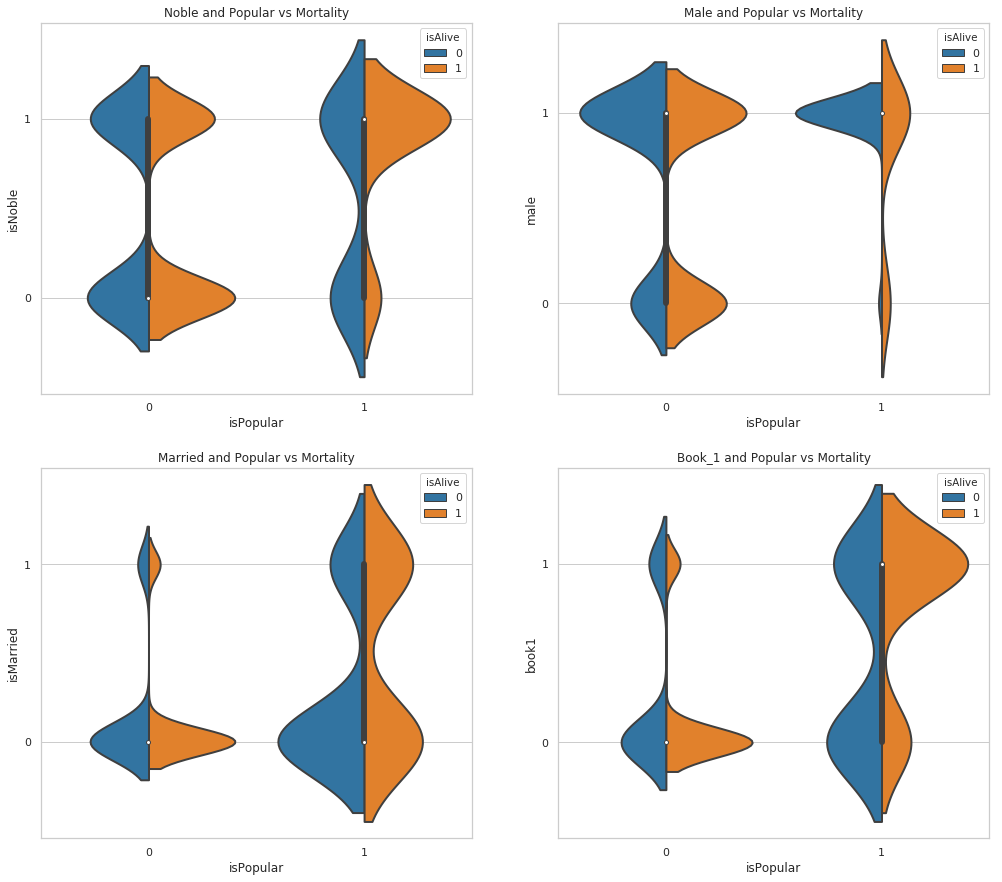

In [13]:
import warnings
warnings.filterwarnings('ignore')
f,ax=plt.subplots(2,2,figsize=(17,15))
sns.violinplot("isPopular", "isNoble", hue="isAlive", data=df ,split=True, ax=ax[0, 0])
ax[0, 0].set_title('Noble and Popular vs Mortality')
ax[0, 0].set_yticks(range(2))

sns.violinplot("isPopular", "male", hue="isAlive", data=df ,split=True, ax=ax[0, 1])
ax[0, 1].set_title('Male and Popular vs Mortality')
ax[0, 1].set_yticks(range(2))

sns.violinplot("isPopular", "isMarried", hue="isAlive", data=df ,split=True, ax=ax[1, 0])
ax[1, 0].set_title('Married and Popular vs Mortality')
ax[1, 0].set_yticks(range(2))


sns.violinplot("isPopular", "book1", hue="isAlive", data=df ,split=True, ax=ax[1, 1])
ax[1, 1].set_title('Book_1 and Popular vs Mortality')
ax[1, 1].set_yticks(range(2))


plt.show()

These plots are usually used to represent the full distribution of the data around some values. For example: On the first plot we can see the distribution of both of our classes **(alive or dead)** on 4 points: *isNoble = 0* and *isPopular = 0* *isNoble = 1* and *isPopular = 0* and so on.

### 4.2 Summary
* Noble and popular most likely alive
* Popular appearing in book1 most likely dead
* Not popular appearing in book1 most likely alive 
* Single and not popular most likely alive
* Single and popular probably dead

As you can see maximizing your chances of surviving the Game Of Thrones is super easy: Just be a **Popular Married Female Noble** and get yourself written into **book 1** (**Cersei Lannister**, **Asha Greyjoy**, **Daenerys Targaryen**, **Sansa Stark**, **Selyse Florent**). Ha! Take that George R. R. Martin.

In [14]:
df.columns[:20]

Index(['S.No', 'actual', 'pred', 'alive', 'plod', 'name', 'title', 'male',
       'culture', 'dateOfBirth', 'DateoFdeath', 'mother', 'father', 'heir',
       'house', 'spouse', 'book1', 'book2', 'book3', 'book4'],
      dtype='object')

### 4.3 Culture
Let's take a look into the **culture** column of our dataset:

In [15]:
# Get all of the culture values in our dataset
set(df['culture'])

{'',
 'Andal',
 'Andals',
 'Asshai',
 "Asshai'i",
 'Astapor',
 'Astapori',
 'Braavos',
 'Braavosi',
 'Crannogmen',
 'Dorne',
 'Dornish',
 'Dornishmen',
 'Dothraki',
 'First Men',
 'Free Folk',
 'Free folk',
 'Ghiscari',
 'Ghiscaricari',
 'Ibbenese',
 'Ironborn',
 'Ironmen',
 'Lhazareen',
 'Lhazarene',
 'Lysene',
 'Lyseni',
 'Meereen',
 'Meereenese',
 'Myrish',
 'Naathi',
 'Northern mountain clans',
 'Northmen',
 'Norvos',
 'Norvoshi',
 'Pentoshi',
 'Qarth',
 'Qartheen',
 'Qohor',
 'Reach',
 'Reachmen',
 'Rhoynar',
 'Riverlands',
 'Rivermen',
 'Sistermen',
 'Stormlander',
 'Stormlands',
 'Summer Islander',
 'Summer Islands',
 'Summer Isles',
 'The Reach',
 'Tyroshi',
 'Vale',
 'Vale mountain clans',
 'Valemen',
 'Valyrian',
 'Westerlands',
 'Westerman',
 'Westermen',
 'Westeros',
 'Wildling',
 'Wildlings',
 'free folk',
 'ironborn',
 'northmen',
 'westermen'}

As you can see there are many different values for just one **culture**. For example: **summer islands** we have 3 different values: **summer islands, summer islander, summer isles**. This happens for many of the culture values appearing in our data, so let's put the names representing the same culture under just one name.

In [16]:
# Lots of different names for one culture so lets group them up
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
    'Ironborn': ['ironborn', 'ironmen'],
    'Mereen': ['meereen', 'meereenese'],
    'RiverLands': ['riverlands', 'rivermen'],
    'Vale': ['vale', 'valemen', 'vale mountain clans']
}

def get_cult(value):
    value = value.lower()
    v = [k for (k, v) in cult.items() if value in v]
    return v[0] if len(v) > 0 else value.title()
df.loc[:, "culture"] = [get_cult(x) for x in df["culture"]]

### 4.4 Dropping Columns

In this dataset that are some columns that make the prediction of a character's death unnecessary. For example: **DateoFdeath** already tells you that that character died (unless it's a NAN), **plod** tells you the probability that a character is dead, and so on. 

We will the drop columns that outright tells you if a character is dead or no, otherwise we would be cheating. 

There are also some columns that are useless for our task, like **S.No** which is basically an incremental identifier for each sample, and **name** which is the name of the character. We will drop these columns as well.


In [17]:
# Drop columns 
drop = ["S.No", "pred", "alive", "plod", "name", "isAlive", "DateoFdeath"]
df.drop(drop, inplace=True, axis=1)

# Save a copy of the dataset before one-hot encoding the features
# we will use this later
df2 = df.copy(deep=True)

### 4.5 One-Hot Encoding vs Factorizing


#### 4.5.1 One-Hot Encoding
One hot encoding refers to the process of turning categorical variables into vectors representing the same information in a way that can be fed into a Machine Learning model.  

![One-Hot Encoding](images/one-hot-encode.png)  


In this example Color is categorical variable that can only take **3 possible values**: *Red*, *Yellow* and *Green*.
So to feed this to a model we turn *Red* into a vector with **3 elements** where **every position is 0** except the **first one**, which is **1**. We repeat the process for *Green* but place the **1** on the **second position** and so on for every other possibble value our categorical variable can take.

#### 4.5.2 Factorizing
You might wonder why not just assign one wonder to each value that the categorical variable takes, **e.g (Red=1, Yellow=2, Green=3)**. Well, you could do this, and it will work to an extent, but it depends on your data.  
Remember these numbers will be fed into the model and some operations will be performed on them. If you choose this approach the model might learn that **Green** is more important than **Red** which in our case is not what we want.

**For this particular dataset i've chosen to use the One-Hot encoding approach**.

In [18]:
# Let's turn our categorical features into one-hot encoded variables
df = pd.get_dummies(df)

In [19]:
# Separate our labels from our features
x = df.iloc[:,1:].values
y = df.iloc[:, 0].values

## 5. Evaluating Classifiers

We will now proceed to feed our data to different models and evaluate the performance of each one.

### 5.1 Cross-Validation

In Machine Learning there are several ways the split your data into **training** and **test** sets in order to determine how a model performs on them, making sure that our model performs well no matter how the data is partitioned.

Suppose we have a model with one or more unknown parameters, and a data set to which the model can be fit (the training data set). The fitting process optimizes the model parameters to make the model fit the training data as well as possible. If we then take an independent sample of validation data from the same population as the training data, it will generally turn out that the model does not fit the validation data as well as it fits the training data. The size of this difference is likely to be large especially when the size of the training data set is small, or when the number of parameters in the model is large. Cross-validation is a way to estimate the size of this effect.

There are many different methods to perform cross validation, they can be found [here](https://en.wikipedia.org/wiki/Cross-validation_(statistics)).  

I usually use the **K-Fold** method which consists in splitting your dataset in **K** different groups, perforiming training and validation with each of them.

![K-Fold](images/k-fold.jpg)  
This approach allows us to evaluate the model in a more reliable way, making sure that it performs well all across the data and not on some specific split.

In [20]:
# Split data into 5 equal groups for validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)


### 5.2 Models

I will not go into the inner working of each of the models that I use since this is not the purpose of the blog. For a full explanation of each model you visit:  

* [Logistic Regressor](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)
* [Random Forest](https://towardsdatascience.com/the-random-forest-algorithm-d457d499ffcd)
* [Decision Tree](https://medium.com/deep-math-machine-learning-ai/chapter-4-decision-trees-algorithms-b93975f7a1f1)
* [SVM](https://scikit-learn.org/stable/modules/svm.html)
* [KNN](https://www.analyticsvidhya.com/blog/2018/03/introduction-k-neighbours-algorithm-clustering/)

In [21]:
# Let's build different models to train with our data
models = [LogisticRegression(solver='liblinear'), RandomForestClassifier(n_estimators=400, random_state=seed), 
          DecisionTreeClassifier(random_state=seed), svm.SVC(kernel='rbf', gamma='scale', random_state=seed), 
          KNeighborsClassifier()]

In [22]:
# Validate each model using K-fold cross validation
mean=[]
std=[]
for model in models:
    result = cross_val_score(model, x, y, cv=kfold, scoring="accuracy", n_jobs=-1)
    mean.append(result)
    std.append(result)

### 5.3 Visualize the Performance

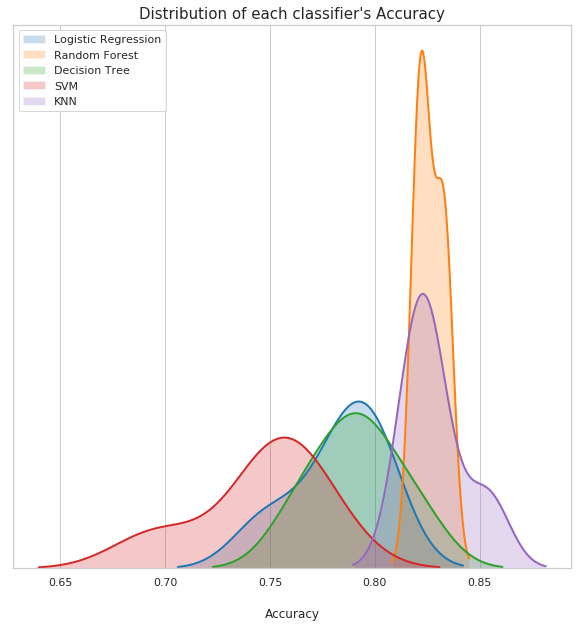

In [23]:
classifiers=['Logistic Regression', 'Random Forest', 'Decision Tree', 'SVM', 'KNN']

plt.figure(figsize=(10, 10))
for i in range(len(mean)):
    sns.distplot(mean[i], hist=False, kde_kws={"shade": True})
    
plt.title("Distribution of each classifier's Accuracy", fontsize=15)
plt.legend(classifiers)
plt.xlabel("Accuracy", labelpad=20)
plt.yticks([])

plt.show()

It seems like **Random Forest** is the most **reliable model** when maximizing **accuracy** since its standard deviation is low and thus the accuracy values it yields do not vary much.

Our **SVM** perform much worse than expected let's see if we can improve them with some tuning.

**We will continue onward analyzing these 2 models more in depth: since the Random Forest shows the highest potential and since our SVM can probably do much better if we tune it's hyper-parameters a little**.

### 5.4 Grid Search

Grid search in basic sense, is a brute force method to estimate hyper-parameters. Say you have k hyper-parameters, and each one of them have c bpossible values. Then, performing grid search is basically taking a Cartesian product of these: 

So you end up having: $\prod_{c=1}^{k}c_i$ possible combinations of hyper-parameters. Running a model so many times it's inneficient but we will use it nonetheless.  

**For a more efficient hyper-parameter search algorithm, take a look at [Random Search](http://www.jmlr.org/papers/v13/bergstra12a.html)**

In [24]:
c = [0.1, 0.3, 0.5, 0.7, 0.9]
gamma = [0.1, 0.3, 0.5, 0.7, 0.9]
kernel = ['rbf','linear']

hyper_parameters = {'kernel': kernel, 'C': c, 'gamma': gamma}

gs = GridSearchCV(estimator=svm.SVC(), param_grid=hyper_parameters,verbose=True, cv=kfold, n_jobs=-1)

# Find the best hyper-parameters using grid-search (this might take a while)
gs.fit(x,y)
print(gs.best_score_)
print(gs.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 17.5min finished


0.829393627954779
SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


**Indeed it seems like our svm can perform much better with some tuning achieving an accuracy of 83%**. This shows the importance of using the right hyper-parameters for any model.

### 5.5 Predictions

Now that we know the best models we can train them with our data and make a **deeper analysis of their performance**. Since we know the best models to further evaluate them we will use **Hold-Out** (split the data 80/20 into train and test set), just to keep the code simple.

In [25]:
# Split data keeping 80% for training and the rest for test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, 
                                                    shuffle=True, random_state=seed)

In [26]:
%%capture
# Now that we know the best configuration we can use it to predict character deaths
svm_clf = svm.SVC(C=0.9, gamma=0.1, kernel='rbf', probability=True, random_state=seed)
rf_clf = RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=seed)

# Train our classfiers
svm_clf.fit(x_train, y_train)
rf_clf.fit(x_train, y_train)

In [27]:
# Get the probability of assigning each sample to either class
svm_prob = svm_clf.predict_proba(x_test)
rf_prob = rf_clf.predict_proba(x_test)

# Get the actual predictions
svm_preds = np.argmax(svm_prob, axis=1)
rf_preds = np.argmax(rf_prob, axis=1)

## 6. Performance Analysis

### 6.1 Confusion Matrix  
A confusion matrix tells us how well a model performs on each of the classes it is trained to predict. 

![Confusion Matrix](images/Confusion-matrix-example.png)  

We want the values on the diagonal to be as high as possible, maximizing the amount of **True Positives** and **True Negatives** our model finds. 

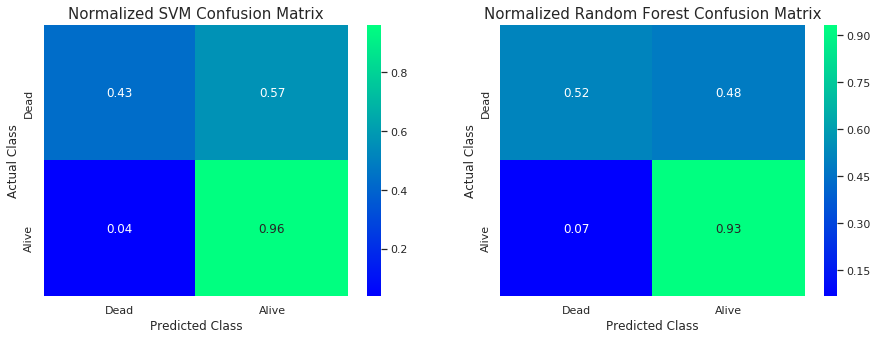

In [28]:
cm = confusion_matrix(y_test, svm_preds)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm2 = confusion_matrix(y_test, rf_preds)
cm2 = cm2.astype('float') / cm2.sum(axis=1)[: , np.newaxis]

classes = ["Dead", "Alive"]
f, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title("Normalized SVM Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[0]).set(xlabel="Predicted Class", ylabel="Actual Class")

ax[1].set_title("Normalized Random Forest Confusion Matrix", fontsize=15.)
sns.heatmap(pd.DataFrame(cm2, index=classes, columns=classes), 
            cmap='winter', annot=True, fmt='.2f', ax=ax[1]).set(xlabel="Predicted Class", 
                                                                ylabel="Actual Class")
plt.show()

We can see that both of our models perform reasonably well on samples belonging to the **Dead** class and very well on samples belonging to the rest.

### 6.2 ROC Curve

So far we have only measured the **accuracy** of a model but there are many more metrics that are important and must be taken into account. In fact, **accuracy** is not the best metrics because it is heavily misleading when there is a class imbalance. For example, consider a dataset where **99%** of the samples belong to **class 0** and **1%** of the samples belong to **class 1**. In this case if model just learns to classify everyhing as  **class 0**, it will reach an **accuracy** of **99%**, and yet this is not a good model.  

The **ROC (Receiver Operating Characteristics) Curve** is a way of visualizing how well our model distinguishes between classes, the higher the area under the curve **AUC** the better the model. This is a much better indicator of a model's performance than just the accuracy.

You can find a much more detailed explanation of this metric [here](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

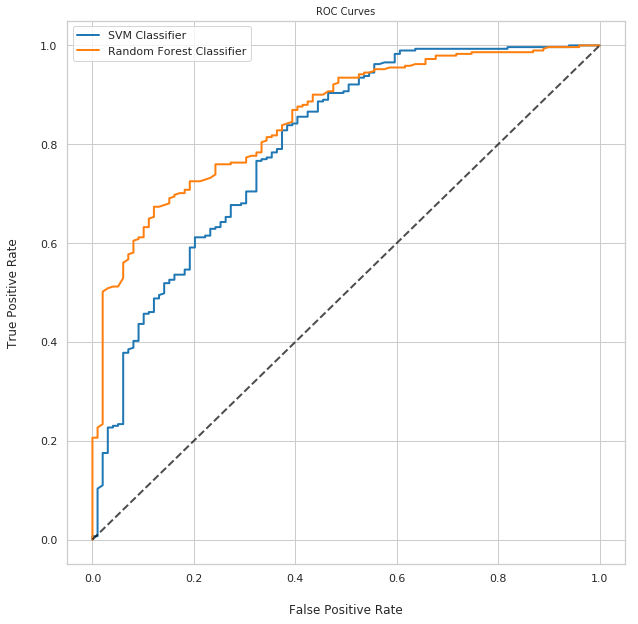

In [29]:
fig = plt.figure(figsize=(10, 10))
plt.plot(*roc_curve(y_test, svm_prob[:, 1])[:2])
plt.plot(*roc_curve(y_test, rf_prob[:, 1])[:2])
plt.legend(["SVM Classifier", "Random Forest Classifier"], loc="upper left")
plt.plot((0., 1.), (0., 1.), "--k", alpha=.7) 
plt.xlabel("False Positive Rate", labelpad=20)
plt.ylabel("True Positive Rate", labelpad=20)
plt.title("ROC Curves", fontsize=10)
plt.show()

### 6.3 More Metrics

For a full analysis of the model's performance let's evaluate the following metrics:

* Precision: $\frac{TP}{TP + FP}$ This indicates how precise is the model when classifying positives samples
* Recall: $\frac{TP}{TP + FN}$ This indicates how well our model finds positives samples out of all the positives samples.

So, what is better, maximizing **precision** or maximizing **recall**? Well this depends on what the model is for. If the cost of a **False Positive** is high then you might be better of just maximizing your precision. But if the cost of **Missing a Positive example** then you should maximize recall.  
For the cases where both recall and precision must be as high as possible, we can use yet another metric:

* F1-Score: $2*\frac{Precision*Recall}{Precision + Recall}$ Maximizing this metric will yield a nice balance between precision and recall

### 6.4 Precision-Recall Curve

A good way to visualize this precision-recall relation is a precision-recall curve. Let's plot one for our Random Forest

Text(0.5,1,'Precision-Recall curve')

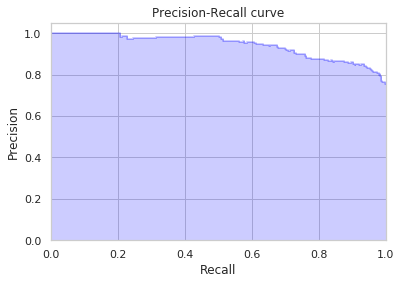

In [30]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature

precision, recall, _ = precision_recall_curve(y_test, rf_prob[:, 1])

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

In [31]:
# So lets take a look at how each model performs on each metric 
print("SVM Classifier Performance")
print("=" * 27)
print(classification_report(y_test, svm_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, svm_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, svm_prob[:, 1])))
print("\n")

print("Random Forest Classifier Performance")
print("=" * 37)
print(classification_report(y_test, rf_preds, target_names=classes))
print("Accuracy: {:.2f}".format(accuracy_score(y_test, rf_preds)))
print("AUC score: {:.2f}".format(roc_auc_score(y_test, rf_prob[:, 1])))
print("\n")

SVM Classifier Performance
              precision    recall  f1-score   support

        Dead       0.80      0.43      0.56        99
       Alive       0.83      0.96      0.89       291

   micro avg       0.83      0.83      0.83       390
   macro avg       0.81      0.70      0.73       390
weighted avg       0.82      0.83      0.81       390

Accuracy: 0.83
AUC score: 0.80


Random Forest Classifier Performance
              precision    recall  f1-score   support

        Dead       0.73      0.52      0.60        99
       Alive       0.85      0.93      0.89       291

   micro avg       0.83      0.83      0.83       390
   macro avg       0.79      0.72      0.75       390
weighted avg       0.82      0.83      0.82       390

Accuracy: 0.83
AUC score: 0.85




It seems that our Random Forest **outperforms** our SVM slightly, specially **distinguishing** between negatives and positives examples as indicated by the **AUC score**.

### 6.5 Feature Importance  

Finally we can take a look inside our model, and learn what features it considers important in order to classify a sample from our dataset.

Since the use of **dummy variables**(created by the **One-Hot Encoding**), yields a very large amount of features, it is hard to visualize the feature importance.

Let's **factorize** our features instead and train our models with the factorized data. Even though it isn't the best approach for processing data it will work just fine for feature importance visualization.

In [32]:
# Factorize our categorical features
df2.loc[:, "title"] = pd.factorize(df2["title"])[0]
df2.loc[:, "culture"] = pd.factorize(df2["culture"])[0]
df2.loc[:, "mother"] = pd.factorize(df2["mother"])[0]
df2.loc[:, "father"] = pd.factorize(df2["father"])[0]
df2.loc[:, "heir"] = pd.factorize(df2["heir"])[0]
df2.loc[:, "house"] = pd.factorize(df2["house"])[0]
df2.loc[:, "spouse"] = pd.factorize(df2["spouse"])[0]

In [33]:
# Split data from labels
x = df2.iloc[:,1:].values
y = df2.iloc[:, 0].values

df2.drop(["actual"], inplace=True, axis=1)

Text(0.5,1,'Random Forest Feature Importance')

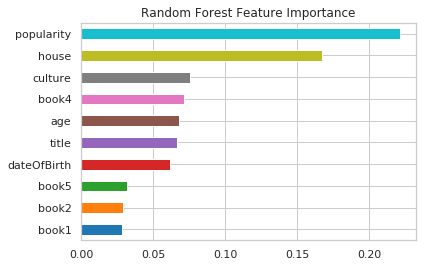

In [34]:
rf_clf.fit(x,y)

# Plot the 10 most important features
plt.figure()
pd.Series(rf_clf.feature_importances_, 
          df2.columns).sort_values(ascending=True)[15:].plot.barh(width=0.5,ax=plt.gca())
plt.gca().set_title('Random Forest Feature Importance')

It seems that **popularity** is the factor that our Random Forest *listens* to the most in order to determine if some character will die. This makes sense, since it is much **more likely** that an **unpopular** character dies just because there are **many more of them**, and even though George R. R. Martin is known for killing popular characters more often than most writers, it seems that he kills **unpopular** characters even more.

## 7. Conclusion

In this post we learned how to **pre-process** data to solve a classification problem, how to determine the **best model** for a task and the **best hyper-parameters** for a model. We also saw the different ways which you can evaluate a classifier and what **metric** to maximize depending on the task at hand. 
Finally we learned how to take a look *inside* a model in order to gain an insight of what **features it considers important** for the task it performs.